# CENG313 Introduction to Data Science
## Assignment 2 - Analyzing a Toy Covid Data: Predict Clinical Cases
## Due: January 22 by 11:59pm

In [1]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from IPython.display import clear_output
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

### Dataset Preparation

#### Loading Data

In [2]:
#read data from given xls ("COVID19 inpatient cases data.xls") (2nd sheet, not first sheet)
#look the first 5 records of data
!pip install --upgrade xlrd

main_df = pd.read_excel("COVID19 inpatient cases data.xls", sheet_name=1)

main_df.head()

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",NaN
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.0
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.0
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",NaN
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.0


In [3]:
# check column names, not null count and data types
print("COLUMN NAMES:\n",main_df.columns)

nulls=main_df.isnull().sum()
print("NOT NULL COUNT:\n",len(main_df)-nulls)

print("DATA TYPES:\n",main_df.dtypes)

COLUMN NAMES:
 Index(['Gender', 'Age', 'Clinical classification',
       'Days from symptoms to hospital', 'No comorbidity',
       'Cardiovascular and\ncerebrovascular disease',
       'Endocrine system disease', 'Malignant tumor',
       'Respiratory system disease', 'Digestive system disease',
       'Renal disease', 'Liver disease', 'Fever', 'Cough', 'Chest tightness',
       'Fatigue', 'Diarrhea', 'Others', 'Clinical outcome',
       'Hospital stay, days'],
      dtype='object')
NOT NULL COUNT:
 Gender                                         73
Age                                            73
Clinical classification                        73
Days from symptoms to hospital                 73
No comorbidity                                 73
Cardiovascular and\ncerebrovascular disease    73
Endocrine system disease                       73
Malignant tumor                                73
Respiratory system disease                     73
Digestive system disease                    

#### Dataset preprocessing

##### Datasets for FIM and Rule extraction

In [4]:
symptom_cols = ['Fever', 'Cough','Chest tightness', 'Fatigue', 'Diarrhea', 'Others']
# create df_symtoms dataframe including given columns
# add "Covid19" columns assign all entries as "Y"
df_symptoms=main_df[symptom_cols].copy()
df_symptoms["Covid19"]='Y'
df_symptoms

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
0,Y,Y,Y,Y,Y,N,Y
1,Y,Y,Y,N,N,N,Y
2,Y,Y,N,N,N,N,Y
3,N,N,N,N,N,N,Y
4,Y,Y,Y,N,N,N,Y
...,...,...,...,...,...,...,...
68,Y,Y,N,N,N,N,Y
69,N,Y,N,Y,N,N,Y
70,N,Y,N,N,N,N,Y
71,Y,Y,N,N,N,N,Y


In [5]:
disease_cols = ['Cardiovascular and\ncerebrovascular disease', 'Endocrine system disease','Malignant tumor','Respiratory system disease',
                'Digestive system disease','Renal disease','Liver disease']
other_cols= ['Age','Gender']
# create df_diseases dataframe consisting records of given cols(disease_cols and other_cols) from main dataframe
# add also "Clinicial classification" attribute from main dataframe calling  this column as "Illness" in your df_diseases dataframe
# add " ill" string to all records in "illness" attribute
df_diseases=main_df[disease_cols].copy()
df_diseases[other_cols]=main_df[other_cols]
df_diseases['Illness']=main_df['Clinical classification']
df_diseases['Illness']=df_diseases['Illness']+" ill"
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Age,Gender,Illness
0,N,N,N,N,N,N,N,47,Male,Heavy ill
1,N,N,N,N,N,N,N,53,Female,Ordinary ill
2,N,N,N,N,N,N,N,57,Female,Ordinary ill
3,N,Y,N,N,N,N,N,58,Male,Heavy ill
4,N,N,N,N,N,N,N,54,Male,Ordinary ill
...,...,...,...,...,...,...,...,...,...,...
68,N,N,N,N,N,N,N,30,Female,Ordinary ill
69,N,Y,N,N,N,N,N,59,Female,Ordinary ill
70,Y,N,N,N,N,N,N,87,Female,Ordinary ill
71,Y,N,N,N,N,N,N,56,Female,Ordinary ill


In [6]:
# categorize ages as "Elderly" (Age>=65),
#                        "Adults" (18<= Age <65),
#                        "Teens" (12=<Age<18),
#                        "Children" (1<Age<11),
#                        "Infants" (Age<=1)
# in new column "Age Group", drop "Age" column in df_disease dataframe.
age_group=[(0,"Infants"),(1,"Children"),(12,"Teens"),(18,"Adults"),(65,"Elderly")]
age_bins = [-1, 1, 11, 18, 65, float('inf')]
age_labels = ['Infants', 'Children', 'Teens', 'Adults', 'Elderly']

age_group_column=pd.cut(df_diseases['Age'], bins=age_bins, labels=age_labels)
df_diseases['Age Group']=age_group_column
df_diseases=df_diseases.drop(columns='Age', axis=1)

df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender,Illness,Age Group
0,N,N,N,N,N,N,N,Male,Heavy ill,Adults
1,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
2,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
3,N,Y,N,N,N,N,N,Male,Heavy ill,Adults
4,N,N,N,N,N,N,N,Male,Ordinary ill,Adults
...,...,...,...,...,...,...,...,...,...,...
68,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
69,N,Y,N,N,N,N,N,Female,Ordinary ill,Adults
70,Y,N,N,N,N,N,N,Female,Ordinary ill,Elderly
71,Y,N,N,N,N,N,N,Female,Ordinary ill,Adults


In [7]:
# Convert "Gender", "Illness", "Age Group" attributes to dummies for one-hot encoding, \
#  then drop these attributes from df_diseases
df_diseases=pd.get_dummies(df_diseases,columns=['Gender','Illness','Age Group'])
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Infants,Age Group_Children,Age Group_Teens,Age Group_Adults,Age Group_Elderly
0,N,N,N,N,N,N,N,False,True,True,False,False,False,False,True,False
1,N,N,N,N,N,N,N,True,False,False,True,False,False,False,True,False
2,N,N,N,N,N,N,N,True,False,False,True,False,False,False,True,False
3,N,Y,N,N,N,N,N,False,True,True,False,False,False,False,True,False
4,N,N,N,N,N,N,N,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,N,N,N,N,N,N,N,True,False,False,True,False,False,False,True,False
69,N,Y,N,N,N,N,N,True,False,False,True,False,False,False,True,False
70,Y,N,N,N,N,N,N,True,False,False,True,False,False,False,False,True
71,Y,N,N,N,N,N,N,True,False,False,True,False,False,False,True,False


In [8]:
# convert all data to bool (True or False) (by replacing or mapping attribute values ) for df_symptoms dataframe
df_symptoms=df_symptoms.replace({'Y':True, 'N':False})
df_symptoms

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
0,True,True,True,True,True,False,True
1,True,True,True,False,False,False,True
2,True,True,False,False,False,False,True
3,False,False,False,False,False,False,True
4,True,True,True,False,False,False,True
...,...,...,...,...,...,...,...
68,True,True,False,False,False,False,True
69,False,True,False,True,False,False,True
70,False,True,False,False,False,False,True
71,True,True,False,False,False,False,True


In [9]:
# same for df_diseases dataframe
df_diseases=df_diseases.replace({'Y':True, 'N':False})
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Infants,Age Group_Children,Age Group_Teens,Age Group_Adults,Age Group_Elderly
0,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False
1,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False
2,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False
3,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False
69,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False
70,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
71,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False


In [10]:
# install mlxtend library
!pip install mlxtend

In [11]:
# create "df_symptoms_extended" concatanating df_symptoms with df_diseases dummy attributes of "Gender", "Illness", "Age Group" and their records.
# drop "Covid19" attribute in extended dataframe
selected_diseases_columns=df_diseases.columns[df_diseases.columns.str.contains('Gender|Illness|Age Group')]
short_diseases=df_diseases[selected_diseases_columns]

df_symptoms_extended = pd.concat([df_symptoms, short_diseases],axis=1)
df_symptoms_extended=df_symptoms_extended.drop("Covid19", axis=1)
df_symptoms_extended

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Infants,Age Group_Children,Age Group_Teens,Age Group_Adults,Age Group_Elderly
0,True,True,True,True,True,False,False,True,True,False,False,False,False,True,False
1,True,True,True,False,False,False,True,False,False,True,False,False,False,True,False
2,True,True,False,False,False,False,True,False,False,True,False,False,False,True,False
3,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False
4,True,True,True,False,False,False,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,True,False,False,False,False,True,False,False,True,False,False,False,True,False
69,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False
70,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True
71,True,True,False,False,False,False,True,False,False,True,False,False,False,True,False


#### Fill mising values with KNN

The usage of KNNImputer is not allowed.

In [12]:
# show missing record as (number of missings/total) (should be only "Hospital stay, days")
missing_number = main_df["Hospital stay, days"].isnull().sum()

print("Missing percentage of Hospital stay, days: ",missing_number,"/",len(main_df),"= %",100*missing_number/len(main_df))

Missing percentage of Hospital stay, days:  4 / 73 = % 5.47945205479452


In [13]:
# copy dataframe df1 to df2
# convert bools and strings to numeric attributes ('Male':1, 'Female':2, 'Heavy':1, 'Ordinary':2, 'Y':1, 'N':0)
value_changes={'Male': 1, 'Female': 2, 'Heavy': 1, 'Ordinary': 2, 'Y': 1, 'N': 0}

df2=main_df.copy()
df2=df2.replace(value_changes)
df2

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,1,47,1,15,1,0,0,0,0,0,0,0,1,1,1,1,1,0,"Aggravated,turn to ICU",NaN
1,2,53,2,13,1,0,0,0,0,0,0,0,1,1,1,0,0,0,Improved and discharge,6.0
2,2,57,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,8.0
3,1,58,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"Aggravated,transfer to superior hospital",NaN
4,1,54,2,10,1,0,0,0,0,0,0,0,1,1,1,0,0,0,Improved and discharge,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2,30,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,24.0
69,2,59,2,10,0,0,1,0,0,0,0,0,0,1,0,1,0,0,Improved and discharge,16.0
70,2,87,2,10,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Improved and discharge,14.0
71,2,56,2,20,0,1,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,12.0


In [14]:
def min_max_scale(df):
    numeric_columns = df.select_dtypes(include=['number']).columns
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    scaler = MinMaxScaler()
    df_min_max_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), columns=df[numeric_columns].columns)
    
    df_min_max_scaled=pd.concat([df_min_max_scaled, df[non_numeric_columns]], axis=1)
    return  df_min_max_scaled

def inv_min_max_scale(df, scaled_val):
    numeric_columns = df.select_dtypes(include=['number']).columns
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    scaled_numeric_features = scaled_val[numeric_columns]
    
    scaler = MinMaxScaler()
    first_features = pd.DataFrame(scaler.fit(df[numeric_columns]).inverse_transform(scaled_numeric_features),columns=scaled_numeric_features.columns)
    df_inv_min_max_scaled = pd.concat([original_numeric_features, df[non_numeric_columns]], axis=1)
    
    return df_inv_min_max_scaled

In [15]:
# min_max_scale for scaling missing atttribute (you will need for "nan" values)
df2_without_nan = df2['Hospital stay, days'].dropna().values.reshape(-1, 1)

# scale other nonmissing attributes using MinMaxScaler in sklearn
scaler = MinMaxScaler()
scaler.fit(df2_without_nan)

# fill missing values based on KNeighborsRegressor regression in sklearn (for k=7)
df2['Hospital stay, days_scaled'] = df2['Hospital stay, days'].apply(lambda x: scaler.transform([[x]])[0][0] if not np.isnan(x) else np.nan)
X_train = df2[df2['Hospital stay, days'].notna()][other_cols]
y_train = df2[df2['Hospital stay, days'].notna()]['Hospital stay, days_scaled']
X_test = df2[df2['Hospital stay, days'].isna()][other_cols]
regressor = KNeighborsRegressor(n_neighbors=7)
regressor.fit(X_train, y_train)
df2.loc[df2['Hospital stay, days'].isna(), 'Hospital stay, days_scaled'] = regressor.predict(X_test)

# fill df1 missings with given values
# don't forget to convert original range
df2['Hospital stay, days_filled'] = df2['Hospital stay, days_scaled'].apply(lambda x: scaler.inverse_transform([[x]])[0][0] if not np.isnan(x) else np.nan)
main_df['Hospital stay, days'].fillna(df2['Hospital stay, days_filled'], inplace=True)
print( main_df['Hospital stay, days'].isnull().sum())

0


#### Dataset for classification task

In [16]:
# copy df1 to data_df datafarme
# split data: label attribute 'Clinical classification' as Y, features as X (including nonmissing features)
# convert attribute values to 0 and 1 ('Y':1, 'N':0, 'Male':0, "Female":1)
data_df=main_df.copy()

Y = data_df['Clinical classification']
X = data_df.drop('Clinical classification', axis=1)
X = X.replace({'Y': 1, 'N': 0, 'Male': 0, 'Female': 1})
X

,Gender,Age,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,0,47,15,1,0,0,0,0,0,0,0,1,1,1,1,1,0,"Aggravated,turn to ICU",16.142857
1,1,53,13,1,0,0,0,0,0,0,0,1,1,1,0,0,0,Improved and discharge,6.000000
2,1,57,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,8.000000
3,0,58,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"Aggravated,transfer to superior hospital",15.142857
4,0,54,10,1,0,0,0,0,0,0,0,1,1,1,0,0,0,Improved and discharge,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1,30,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,24.000000
69,1,59,10,0,0,1,0,0,0,0,0,0,1,0,1,0,0,Improved and discharge,16.000000
70,1,87,10,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Improved and discharge,14.000000
71,1,56,20,0,1,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,12.000000


In [17]:
# Split dataset as train and test set using sklearn (for random_state=44)
# x_train, x_val, y_test, y_test = # to-do
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=44)

x_train_numerical = x_train.select_dtypes(include=['number'])
x_test_numerical = x_test.select_dtypes(include=['number'])

### Classification Part: Predicting Clinical Cases

#### Decision Tree Classifier

In [18]:
# create ID3 Tree using sklearn
dt_classifier=DecisionTreeClassifier(random_state=44)

# train Decision Tree Classifier
dt_classifier.fit(x_train_numerical, y_train)

# Predict classes for test data
predictions = dt_classifier.predict(x_test_numerical)

# calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure, confusion matrix
#           based on your defined functions
accuracy=accuracy_score(y_test,predictions)
cm=confusion_matrix(y_test,predictions)
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
sensitivity=tp/(tp+fn)
specificity =tn/(tn+fp)

print("Accuracy: ",accuracy)
print("Error: ",1-accuracy)
print("Recall: ",recall_score(y_test,predictions,pos_label='Ordinary'))
print("Precision: ",precision_score(y_test,predictions,pos_label='Ordinary'))
print("Sensitivity: ",sensitivity)
print("Specifity: ",specificity)
print("F1 Measure: ",f1_score(y_test,predictions,pos_label='Ordinary'))
print("Confusion Matrix: \n",cm)

Accuracy:  0.7368421052631579
Error:  0.26315789473684215
Recall:  0.9166666666666666
Precision:  0.7333333333333333
Sensitivity:  0.9166666666666666
Specifity:  0.42857142857142855
F1 Measure:  0.8148148148148148
Confusion Matrix: 
 [[ 3  4]
 [ 1 11]]


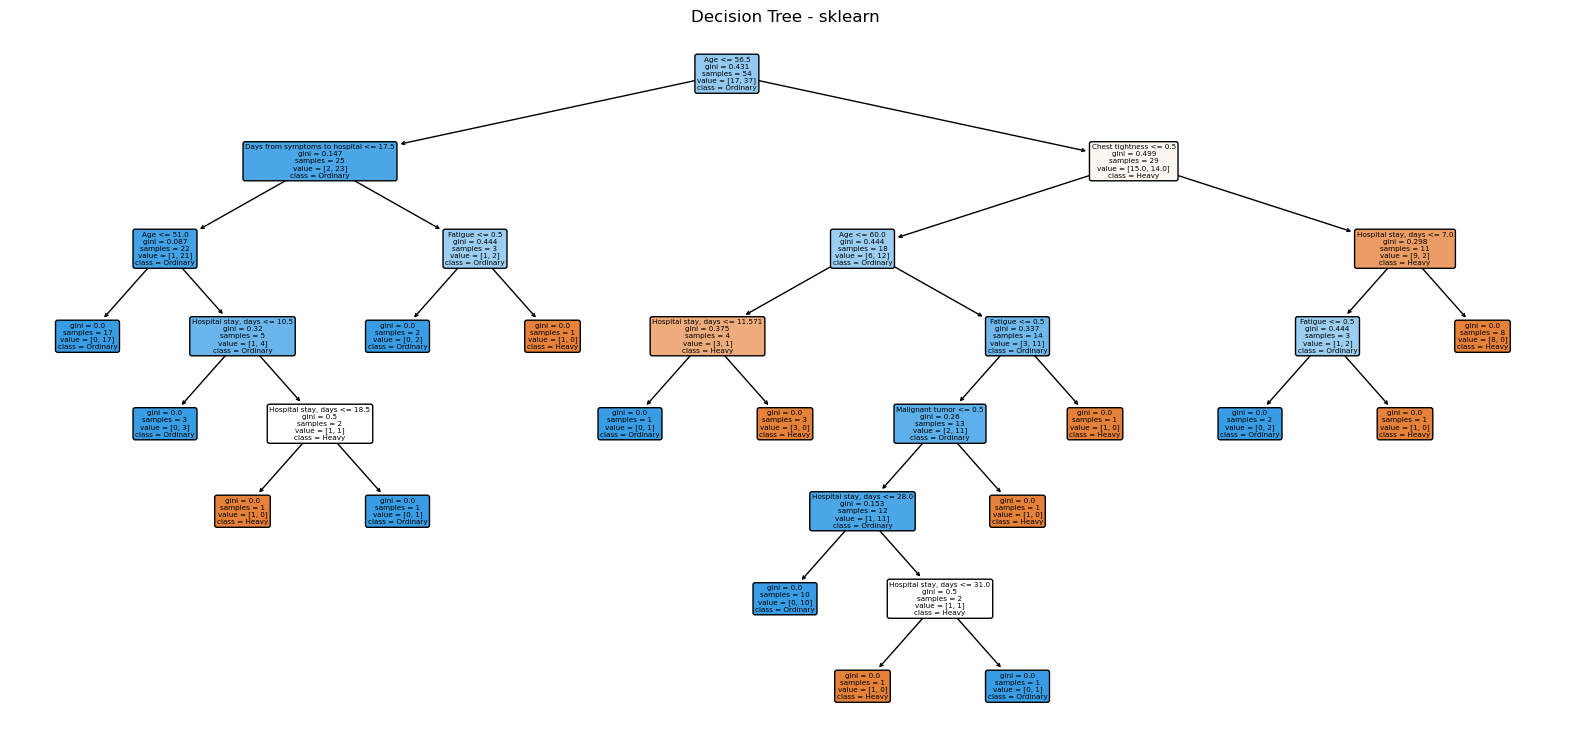

In [19]:
# visualize your tree using plot_tree inside sklearn and dtreeplt
# !pip install dtreeplt
!pip install dtreeplt
clear_output()

temp_X=X.select_dtypes(include=['number'])
model = dt_classifier

class_names=sorted(Y.unique())
feature_names=temp_X.columns.tolist()

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names, rounded=True)
plt.title('Decision Tree - sklearn')

plt.show()

#### KNN Classifier

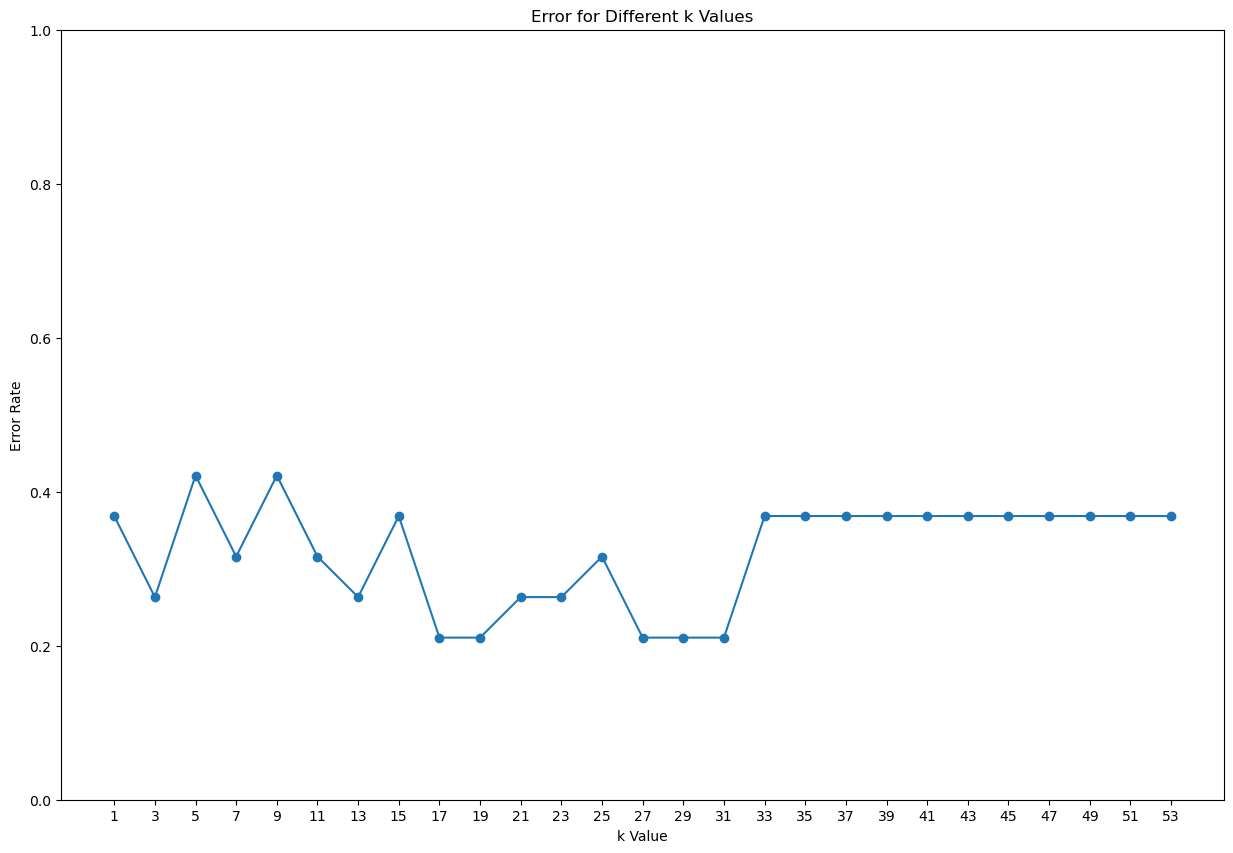

In [20]:
# classify test data with KNN classifier of sklearn (for each possible k value)

# calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure, confusion matrix
#           based on your defined functions (using k=7)

# plot test errors for each k
k_values=range(1,54)[::2]
accuracies = []
errors = []
recalls = []
precisions = []
sensivities = []
specifities = []
f1s = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k).fit(x_train_numerical, y_train)
    predictions = knn_classifier.predict(x_test_numerical)
    
    accuracies.append(accuracy_score(y_test,predictions))
    errors.append(1 - accuracy_score(y_test, predictions))
    cm=confusion_matrix(y_test,predictions)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    sensivities.append(tp/(tp+fn))
    specifities.append(tn/(tn+fp))
    recalls.append(recall_score(y_test,predictions,pos_label='Ordinary'))
    precisions.append(precision_score(y_test,predictions,pos_label='Ordinary'))
    f1s.append(f1_score(y_test,predictions,pos_label='Ordinary'))
    
plt.figure(figsize=(15, 10))
plt.plot(k_values,errors,marker='o')
plt.title('Error for Different k Values')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.ylim([0, 1])
plt.xticks(list(k_values))
plt.show()

### Evaluation Part: Decision Boundries, ROC Curves, Performance Comparisons

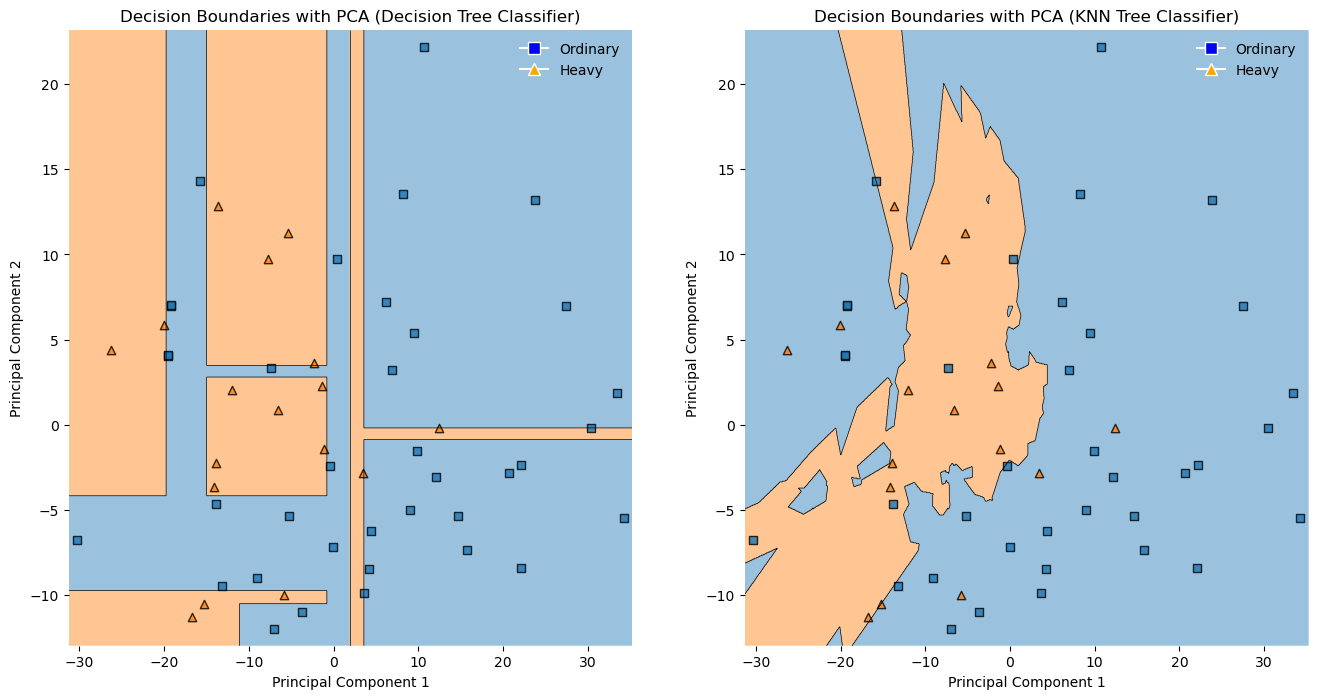

In [21]:
# show decision boundaries for each classifiers on same plot (show pairwise since we have more than 2 attiributes)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train_numerical)
X_test_pca = pca.transform(x_test_numerical)

y_train_binary = y_train.map({'Ordinary': 0, 'Heavy': 1}).values.astype(int)


clf_dt = DecisionTreeClassifier(random_state=44)
clf_dt.fit(X_train_pca, y_train_binary)
clf_knn = KNeighborsClassifier(n_neighbors=7)
clf_knn.fit(X_train_pca, y_train_binary)


plt.figure(figsize=(16, 8))
custom_handles = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=8, label='Ordinary'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='orange', markersize=8, label='Heavy')
]

plt.subplot(1,2,1)
plot_decision_regions(X=X_train_pca, y=y_train_binary, clf=clf_dt, legend=2)
plt.title('Decision Boundaries with PCA (Decision Tree Classifier)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=custom_handles, loc='upper right',frameon=False)

plt.subplot(1,2,2)
plot_decision_regions(X=X_train_pca, y=y_train_binary, clf=clf_knn, legend=2)
plt.title('Decision Boundaries with PCA (KNN Tree Classifier)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=custom_handles, loc='upper right',frameon=False)

plt.show()

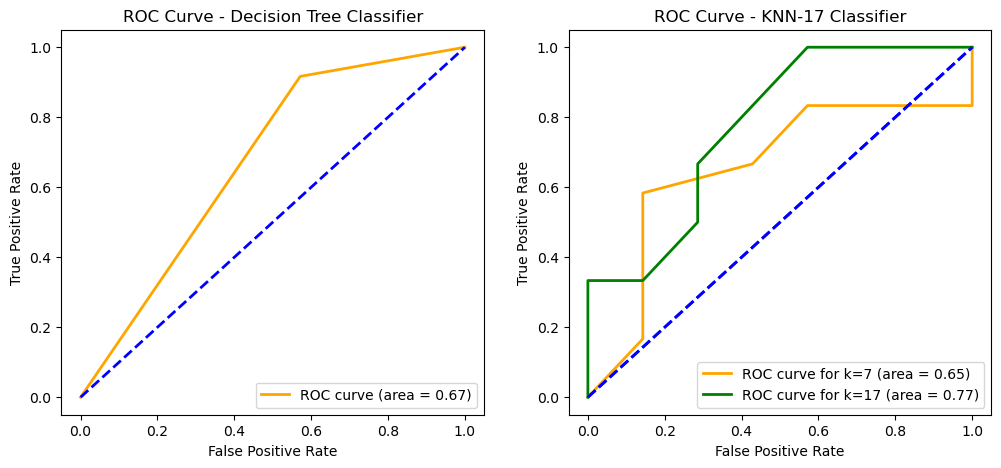

In [22]:
# draw ROC curves for each classifier

knn_classifier_7 = KNeighborsClassifier(n_neighbors=7).fit(x_train_numerical, y_train)
knn_classifier_17 = KNeighborsClassifier(n_neighbors=17).fit(x_train_numerical, y_train)
dt_classifier=DecisionTreeClassifier(random_state=44).fit(x_train_numerical, y_train)

# Compute ROC curve and area under the curve
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_classifier.predict_proba(x_test_numerical)[:, 1],pos_label="Ordinary")
dt_roc_auc = auc(dt_fpr, dt_tpr)

knn_fpr_7, knn_tpr_7, knn_thresholds_7 = roc_curve(y_test, knn_classifier_7.predict_proba(x_test_numerical)[:, 1],pos_label="Ordinary")
knn_roc_auc_7 = auc(knn_fpr_7, knn_tpr_7)

knn_fpr_17, knn_tpr_17, knn_thresholds_17 = roc_curve(y_test, knn_classifier_17.predict_proba(x_test_numerical)[:, 1],pos_label="Ordinary")
knn_roc_auc_17 = auc(knn_fpr_17, knn_tpr_17)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dt_fpr, dt_tpr, color='orange', lw=2, label='ROC curve (area = {:.2f})'.format(dt_roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(knn_fpr_7, knn_tpr_7, color='orange', lw=2, label='ROC curve for k=7 (area = {:.2f})'.format(knn_roc_auc_7))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN-7 Classifier')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(knn_fpr_17, knn_tpr_17, color='green', lw=2, label='ROC curve for k=17 (area = {:.2f})'.format(knn_roc_auc_17))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN-17 Classifier')
plt.legend(loc='lower right')

plt.show()

In [23]:
# show classification results based on all measures (acc,err,recall, specifity, etc.) inside a table.
knn_classifier = KNeighborsClassifier(n_neighbors=7).fit(x_train_numerical, y_train)
y_pred_knn = knn_classifier.predict(x_test_numerical)
knn_classifier_17 = KNeighborsClassifier(n_neighbors=17).fit(x_train_numerical, y_train)
y_pred_knn_17 = knn_classifier_17.predict(x_test_numerical)
dt_classifier=DecisionTreeClassifier(random_state=44).fit(x_train_numerical, y_train)
y_pred_dt = dt_classifier.predict(x_test_numerical)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
error_knn = 1-accuracy_knn
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
sensitivity_knn = conf_matrix_knn[1,1]/(conf_matrix_knn[1,1]+conf_matrix_knn[1,0])
specifity_knn = conf_matrix_knn[0,0]/(conf_matrix_knn[0,0]+conf_matrix_knn[0,1])
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

conf_matrix_knn_17 = confusion_matrix(y_test, y_pred_knn_17)
accuracy_knn_17 = accuracy_score(y_test, y_pred_knn_17)
error_knn_17 = 1-accuracy_knn_17
recall_knn_17 = recall_score(y_test, y_pred_knn_17, average='weighted')
precision_knn_17 = precision_score(y_test, y_pred_knn_17, average='weighted')
sensitivity_knn_17 = conf_matrix_knn[1,1]/(conf_matrix_knn[1,1]+conf_matrix_knn[1,0])
specifity_knn_17 = conf_matrix_knn[0,0]/(conf_matrix_knn[0,0]+conf_matrix_knn[0,1])
f1_knn_17 = f1_score(y_test, y_pred_knn_17, average='weighted')

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
error_dt = 1-accuracy_dt
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
sensitivity_dt = conf_matrix_dt[1,1]/(conf_matrix_dt[1,1]+conf_matrix_dt[1,0])
specifity_dt = conf_matrix_dt[0,0]/(conf_matrix_dt[0,0]+conf_matrix_dt[0,1])
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

data = {
    'Metric': ['Accuracy','Error','Recall','Precision', 'Sensitivity','Specifity', 'F1 Measure'],
    'k-NN(7)': [accuracy_knn, error_knn, recall_knn, precision_knn, sensitivity_knn, specifity_knn, f1_knn],
    'k-NN(17)': [accuracy_knn_17, error_knn_17, recall_knn_17, precision_knn_17, sensitivity_knn_17, specifity_knn_17, f1_knn_17],
    'Decision Tree': [accuracy_dt, error_dt, recall_dt, precision_dt, sensitivity_dt, specifity_dt, f1_dt]
}

df = pd.DataFrame(data)
print("Confusion Matrix for k-NN(7):")
print(conf_matrix_knn)

print("\nConfusion Matrix for k-NN(17):")
print(conf_matrix_knn_17)

print("\nConfusion Matrix for Decision Tree:")
print(conf_matrix_dt)

# Display the table
print("\nClassification Metrics:")
print(df)

Confusion Matrix for k-NN(7):
[[ 3  4]
 [ 2 10]]

Confusion Matrix for k-NN(17):
[[ 3  4]
 [ 0 12]]

Confusion Matrix for Decision Tree:
[[ 3  4]
 [ 1 11]]

Classification Metrics:
        Metric   k-NN(7)  k-NN(17)  Decision Tree
0     Accuracy  0.684211  0.789474       0.736842
1        Error  0.315789  0.210526       0.263158
2       Recall  0.684211  0.789474       0.736842
3    Precision  0.672180  0.842105       0.739474
4  Sensitivity  0.833333  0.833333       0.916667
5    Specifity  0.428571  0.428571       0.428571
6   F1 Measure  0.670040  0.762406       0.715577
